In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from dgl.nn import EdgeWeightNorm, GraphConv
from dgl.data import DGLDataset
import mysql.connector
import dgl.data
import numpy as np
import pandas as pd
import os
from dgl import save_graphs, load_graphs
import matplotlib.pyplot as plt
import random
from Datasets import PaperDataset
from Models import GraphClassificationModelCrossEntropy, GraphClassificationModelBinaryCrossEntropy

# Connect to database

In [2]:
cnx = mysql.connector.connect(user='david', password='daviddung1993',
                          host='127.0.0.1',
                          database='computervision')
cursor = cnx.cursor()
headers = {"x-api-key": "M7HSjQNeTfai6l7JUiDZB8XYc85BHnHt3R0NXSEd"}

## Create Paper Graph

In [3]:
# need to define max year due to memory limitations
max_year = 2009

In [4]:
cursor.execute("select r.ReferenceID as rID, p.PaperID as pID from Papers p, referencedBy r where p.Leaf = False and p.authorCount = 1 and p.Pub_Year <= %s and r.ReferencedByID = p.PaperID and r.ReferenceID not like '11111%'", [max_year])

# Fetch references (edges)
references_raw = cursor.fetchall()
references_df = pd.DataFrame(references_raw, columns=["ReferenceID","PaperID"])

# Fetch all papers (nodes)
cursor.execute("CREATE TEMPORARY TABLE temp_table AS (select p.PaperID as PaperID from Papers p where p.Leaf = False and p.Pub_Year <= %s and p.authorCount = 1  UNION select r.ReferenceID as PaperID from Papers p, referencedBy r where p.Leaf = False and p.Pub_Year <= %s and p.authorCount = 1 and r.ReferencedByID = p.PaperID and r.ReferenceID not like '11111%')", [max_year, max_year])
cursor.execute("select * from temp_table")
all_papers_series = cursor.fetchall()

all_papers_remap_ids = {all_papers_series[x][0]: x for x in range(0, len(all_papers_series))}

# Remap the references to id
references_df = references_df.applymap(lambda x: all_papers_remap_ids[x])

# Fetch authors and remap to label
cursor.execute("select b.PaperID, b.AuthoredByID from authoredBy b, temp_table t where b.PaperID = t.PaperID")
authored_by_df = pd.DataFrame(cursor.fetchall(), columns=["PaperID", "AuthorID"])
authored_by_df["PaperID"] = authored_by_df["PaperID"].apply(lambda x: all_papers_remap_ids[x])

all_author_ids = authored_by_df["AuthorID"].unique()
mapped_author_ids = {all_author_ids[index]: index for index in range(0, len(all_author_ids))}
authored_by_df["AuthorID"] = authored_by_df["AuthorID"].apply(lambda x: mapped_author_ids[x])
total_authors_len = len(authored_by_df["AuthorID"].unique())
feature_vector_df = pd.DataFrame(columns=authored_by_df["AuthorID"].unique())

# Create Validation Set
cursor.execute("select p.PaperID as PaperID from Papers p where p.Leaf = False and p.Pub_Year <= %s and p.authorCount = 1 order by p.Pub_year", [max_year])
val_papers_raw = cursor.fetchall()
reference_paper = pd.DataFrame(val_papers_raw, columns=["PaperID"]).applymap(lambda x: all_papers_remap_ids[x])
reference_paper_w_authors = pd.merge(reference_paper, authored_by_df, on="PaperID")
val_split = int(len(reference_paper_w_authors)*0.2)
reference_paper_w_authors["PaperID"] = reference_paper_w_authors["PaperID"].astype(str)
max_val_size = int(len(reference_paper_w_authors)*0.2)
reference_paper_w_grouped_authors = reference_paper_w_authors.groupby("AuthorID", as_index=False).agg({'PaperID': ','.join})
val_papers_index = []
for grouped_authors in reference_paper_w_grouped_authors.iterrows():
    papers = grouped_authors[1]["PaperID"].split(",")
    if len(papers) > 1:
        val_split = round(len(papers) * 0.33)
        val_papers_index += papers[-val_split:]
        if len(val_papers_index) >= max_val_size:
            break
training_set_index = len(val_papers_raw)

In [5]:
reversed_all_papers_remap_ids = {v: k for k, v in all_papers_remap_ids.items()}
val_set = [reversed_all_papers_remap_ids[int(map_id)] for map_id in val_papers_index]

In [8]:
val_papers_index

['96',
 '41',
 '69',
 '85',
 '97',
 '50',
 '84',
 '87',
 '110',
 '23',
 '81',
 '107',
 '127',
 '118',
 '72',
 '66',
 '122',
 '112',
 '116']

In [7]:
# Init graph
dataset = PaperDataset(authored_by_df, references_df, val_papers_index, training_set_index, one_hot_encoded=True)
paper_graph = dataset[0]
#paper_graph = paper_graph.add_self_loop()

0
1000
2000


/home/david/PycharmProjects/bachelor_thesis/Graph Neural Network/Datasets.py:28: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  node_labels = torch.tensor(feature_vector, dtype=torch.int32)


In [12]:
torch.count_nonzero(paper_graph.ndata["feat"][1])

tensor(1)

In [14]:
# Save the graph
save_graphs("./graphs/single_author_2009_w_labels_test.bin", [paper_graph])

## Load Graph

In [13]:
glist, label_dict = load_graphs("./graphs/single_author_2009_w_labels_test.bin")
paper_graph = glist[0]


DGLError: File ./graphs/single_author_2009_w_labels_test.bin does not exist.

## Graph Neural Network for Paper prediction

In [14]:
# Initialize the model and the loss function
model = GraphClassificationModelBinaryCrossEntropy(3172, 256, paper_graph.ndata["label"].shape[1])
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
model.fit(200,paper_graph,optimizer)

Epoch 0: loss=0.6932, train_acc=0.0000, val_acc=0.0000
Epoch 1: loss=0.1911, train_acc=0.0005, val_acc=0.0000
Epoch 2: loss=0.0125, train_acc=0.0050, val_acc=0.0000
Epoch 3: loss=0.0101, train_acc=0.0050, val_acc=0.0000
Epoch 4: loss=0.0153, train_acc=0.0095, val_acc=0.0000
Epoch 5: loss=0.0191, train_acc=0.0090, val_acc=0.0000
Epoch 6: loss=0.0230, train_acc=0.0090, val_acc=0.0000
Epoch 7: loss=0.0264, train_acc=0.0090, val_acc=0.0000
Epoch 8: loss=0.0293, train_acc=0.0090, val_acc=0.0000
Epoch 9: loss=0.0317, train_acc=0.0090, val_acc=0.0000
Epoch 10: loss=0.0335, train_acc=0.0090, val_acc=0.0000
Epoch 11: loss=0.0347, train_acc=0.0090, val_acc=0.0000
Epoch 12: loss=0.0357, train_acc=0.0080, val_acc=0.1579
Epoch 13: loss=0.0364, train_acc=0.0085, val_acc=0.0000
Epoch 14: loss=0.0364, train_acc=0.0065, val_acc=0.0526
Epoch 15: loss=0.0358, train_acc=0.0105, val_acc=0.0526
Epoch 16: loss=0.0357, train_acc=0.0130, val_acc=0.0000
Epoch 17: loss=0.0352, train_acc=0.0175, val_acc=0.1053
Ep

KeyboardInterrupt: 

In [7]:
torch.save(model.state_dict(), "./models/single_author_2014")

# Initialize Graph

In [87]:
logits = torch.tensor([[-3., -3., 3.]])
F.binary_cross_entropy_with_logits(logits, torch.tensor([[0,0,1]]).float(), pos_weight=torch.tensor([12000.]))

tensor(194.3817)

In [1]:
if not os.path.isfile("./data2.bin"):
    added_labels = []
    cursor.execute("select a.AuthorID from Authors a")
    all_authors = cursor.fetchall()
    all_authors_index = [(x, all_authors[x][0]) for x in range(0, len(all_authors))]
    authors = pd.DataFrame(all_authors_index, columns=["key", "AuthorID"])
    max_id = authors["key"].max()
    complete_references_raw = pd.DataFrame({'key_x' : [],  "key_y" : [], "year": [], "PaperID": []})
    conc_list = []
    # Fetch data per year (otherwise it would crash)
    for year in range(2000,2010):
        print(year)
        cursor.execute(f"select a.AuthoredByID, a2.AuthoredByID, p.Pub_Year, p.PaperID from Papers p, authoredBy a, authoredBy a2, referencedBy b where p.PaperID = b.ReferencedByID and a.AuthoredByID != 0 and p.PaperID = a.PaperID and a2.AuthoredByID != 0 and p.Pub_Year = {year} and b.ReferenceID = a2.PaperID")
        entries = cursor.fetchall()
        entries_df = pd.DataFrame(entries, columns=["A", "B", "year", "PaperID"])
        temp = pd.merge(entries_df, authors, left_on="B", right_on="AuthorID")
        all_references = pd.merge(authors, temp, left_on="AuthorID", right_on="A")
        subset_all_references = all_references[["key_x", "key_y", "year", "PaperID"]]
        complete_references_raw = pd.concat([complete_references_raw, subset_all_references])

    # Choose latest papers with existing authors in the training as validation
    aggregated_references = complete_references_raw.groupby(["PaperID", "key_x", "year"], as_index=False).count()
    author_count = aggregated_references.groupby(["key_x"]).size().reset_index(name='count')
    author_count = author_count[author_count["count"] != 1]
    aggregated_references = pd.merge(aggregated_references, author_count, on="key_x")
    validation_subset_sample = random.sample(range(len(author_count)), int(val_split*len(author_count)))
    for val_id in validation_subset_sample:
        # Get latest paper of that author
        latest_paper_information = aggregated_references[aggregated_references["key_x"] == author_count.iloc[val_id]["key_x"]].sort_values("year").iloc[-1]
        val_author_id = latest_paper_information["key_x"]
        val_paper_id = latest_paper_information["PaperID"]
        val_author_label_id = authors[authors["key"] == val_author_id]["AuthorID"].values[0]
        added_labels.append(val_author_id)
        # Remap the id
        max_id += 1
        authors = pd.concat([authors, pd.DataFrame({"key": [max_id], "AuthorID": [val_author_label_id]})])
        aggregated_references.loc[(aggregated_references["PaperID"] == val_paper_id) & (aggregated_references["key_x"] == val_author_id), ["key_x"]] \
            = max_id
        aggregated_references.drop(aggregated_references.loc[(aggregated_references["PaperID"] == val_paper_id) & (aggregated_references["key_x"] != max_id)].index, inplace=True)


    complete_references_raw = complete_references_raw.groupby(["key_x", "key_y"]).size().reset_index(name='C')
    complete_references_raw = complete_references_raw.rename(columns={"key_x":"Author", "key_y":"RefAuthor", "C":"Count"})
    dataset = AuthorDataset(authors, complete_references_raw)
    graph = dataset[0]
    save_graphs("./data.bin", [graph])
else: # Load graph if exists
    glist, label_dict = load_graphs("./data.bin")
    graph = glist[0]

NameError: name 'os' is not defined

In [100]:
print()

        key_x
190  450237.0


In [107]:
aggregated_references.drop(aggregated_references.loc[(aggregated_references["PaperID"] == val_paper_id) & (aggregated_references["key_x"] != max_id)].index, inplace=True)

In [113]:
aggregated_references.loc[(aggregated_references["PaperID"] == val_paper_id) & (aggregated_references["key_x"] != max_id)].index

Int64Index([], dtype='int64')

## Properties

In [61]:
print(f"Number of nodes: {graph.num_nodes()}")
print(f"Number of edges: {graph.num_edges()}")
in_degrees = graph.in_degrees().numpy()
out_degrees = graph.out_degrees().numpy()

Number of nodes: 733726
Number of edges: 25392667


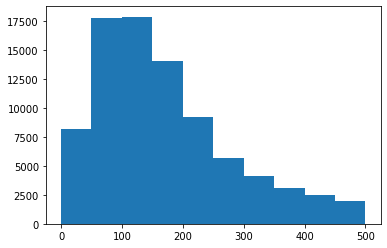

In [43]:
plt.hist(in_degrees[in_degrees != 0], range=(0,500))
plt.show()

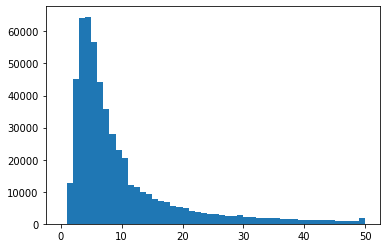

In [57]:
plt.hist(out_degrees[out_degrees != 0], range=(0,50), bins=50)
plt.show()

In [67]:
node_subset = random.sample(range(graph.num_nodes()), 4000)
sub_graph = graph.subgraph(node_subset)

# Graph Neural Network

In [73]:
class GCN(nn.Module):
    def __init__(self, in_feats, hid_feats, out_feats):
        super().__init__()

        self.conv1 = GraphConv(in_feats, hid_feats, allow_zero_in_degree=True, norm='none', weight=True, bias=True)
        self.conv2 = GraphConv(hid_feats, out_feats, allow_zero_in_degree=True, norm='none', weight=True, bias=True)

    def forward(self, graph, inputs, edge_weight):
        norm = EdgeWeightNorm(norm='both')
        norm_edge_weight = norm(graph, edge_weight)
        #print(norm_edge_weight)
        h = self.conv1(graph, inputs, edge_weight=norm_edge_weight)
        h = F.relu(h)
        h = self.conv2(graph, h, edge_weight=norm_edge_weight)
        return h

In [47]:
node_features = graph.ndata['feat'].float()
node_labels = graph.ndata['label']
train_mask = graph.ndata['train_mask']
valid_mask = graph.ndata['val_mask']
test_mask = graph.ndata['test_mask']
edge_weights = graph.edata['weight'].float()
n_features = node_features.shape[1]
n_labels = int(node_labels.max().item() + 1)

In [48]:
def evaluate(model, graph, features, edge_weights, labels, mask):
    model.eval()
    with torch.no_grad():
        logits = model(graph, features, edge_weights)
        logits = logits[mask]
        labels = labels[mask]
        _, indices = torch.max(logits, dim=1)
        print(indices)
        correct = torch.sum(indices == labels)
        return correct.item() * 1.0 / len(labels)

In [50]:
len(edge_weights)

29100277

In [51]:
model = GCN(in_feats=n_features, hid_feats=12, out_feats=n_labels)
opt = torch.optim.Adam(model.parameters())

for epoch in range(10000):
    model.train()
    # forward propagation by using all nodes
    logits = model(graph, node_features, edge_weights)
    # compute loss
    loss = F.cross_entropy(logits[train_mask], node_labels[train_mask].long())
    # compute validation accuracy
    acc = evaluate(model, graph, node_features, edge_weights, node_labels, valid_mask)
    print(acc)
    # backward propagation
    opt.zero_grad()
    loss.backward()
    opt.step()
    print(loss.item())

    # Save model if necessary.  Omitted in this example.

RuntimeError: [enforce fail at alloc_cpu.cpp:75] err == 0. DefaultCPUAllocator: can't allocate memory: you tried to allocate 2153415372304 bytes. Error code 12 (Cannot allocate memory)

# Sample GNN

In [3]:
sample_g = dgl.graph(([1, 2, 2, 1, 1, 3, 3, 2, 3, 2, 5, 1, 2, 2, 1, 3, 2, 5],[0, 0, 1, 3, 4, 4, 5, 6, 6, 7, 7, 8, 8, 9, 10, 10, 11, 11]))
sample_g.ndata['feat'] = torch.randn(12, 1)
sample_g.ndata['label'] = torch.tensor(list(range(8)) + [0, 7,1, 4, 7])
#sample_g.edata['weights'] = torch.tensor([2,2,1,1,1,3,1,1,1,3,1,1,1,1,1,1,1,1]).type(torch.float32)
sample_g.edata['weights'] = torch.tensor([2,2,1,1,1,3,1,1,3,3,1,3,3,3,3,3,3,3]).type(torch.float32)
t_mask = torch.zeros(12, dtype=torch.bool)
v_mask = torch.zeros(12, dtype=torch.bool)
t_mask[:8] = True
v_mask[8:] = True
sample_g.ndata['train_mask'] = t_mask
sample_g.ndata['val_mask'] = v_mask
sample_g.ndata['test_mask'] = v_mask
#sample_g = dgl.add_self_loop(sample_g)

DGLError: Expect number of features to match number of nodes (len(u)). Got 13 and 12 instead.

In [97]:
a = torch.ones(4,5)
torch.sum(a, dim=0)

tensor([4., 4., 4., 4., 4.])

In [70]:
merged_tensor = [torch.zeros(5,5), torch.zeros(5,5)]
torch.stack(merged_tensor, dim=0).shape

torch.Size([2, 5, 5])

In [46]:
torch.randn(5,1)

tensor([[ 1.5373],
        [-0.9285],
        [-0.6500],
        [ 1.0641],
        [ 0.8817]])

In [3]:
sample_g = dgl.DGLGraph()
sample_g.add_nodes(11)
sample_g.add_edges([0,1,2,3,5,6,6,8,9,10,2,3],[1,3,3,4,4,4,7,7,7,7,7,7])
label_tensor = torch.tensor([[1,0,0],[1,0,0],[1,0,0],[1,0,0],[0,1,0],[0,1,0],[0,1,0],[0,0,1],[0,0,1],[0,0,1],[0,0,1]])
feature_tensor = []

rand_feat = torch.randn(11,1)
#sample_g.ndata['feat'] = torch.tensor([[1,0,0],[1,0,0],[1,0,0],[0,0,0],[0,0,0],[0,1,0],[0,1,0],[0,0,0],[0,0,1],[0,0,1],[0,0,1]])
sample_g.ndata['feat'] = torch.cat([rand_feat, label_tensor], dim=1)
sample_g.ndata['label'] = label_tensor
t_mask = torch.zeros(11, dtype=torch.bool)
v_mask = torch.zeros(11, dtype=torch.bool)#
t_mask[3] = True
t_mask[4] = True

v_mask[7] = True
sample_g.ndata['train_mask'] = t_mask
sample_g.ndata['val_mask'] = v_mask
sample_g.ndata['test_mask'] = v_mask
#g = sample_g.add_self_loop()
g = sample_g
#sample_g = sample_g.add_self_loop()

/usr/local/lib/python3.10/dist-packages/dgl/heterograph.py:72: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  dgl_warning('Recommend creating graphs by `dgl.graph(data)`'


In [5]:
model = GraphClassificationModelBinaryCrossEntropy(4, 8, sample_g.ndata["label"].shape[1])
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
model.fit(30,sample_g,optimizer)

tensor([[ 0.3481,  1.0000,  0.0000,  0.0000],
        [ 0.1966,  1.0000,  0.0000,  0.0000],
        [-1.4645,  1.0000,  0.0000,  0.0000],
        [ 1.2140,  1.0000,  0.0000,  0.0000],
        [ 0.2513,  0.0000,  1.0000,  0.0000],
        [ 0.6077,  0.0000,  1.0000,  0.0000],
        [ 1.5089,  0.0000,  1.0000,  0.0000],
        [-0.9404,  0.0000,  0.0000,  1.0000],
        [-1.2057,  0.0000,  0.0000,  1.0000],
        [ 0.4911,  0.0000,  0.0000,  1.0000],
        [ 0.9173,  0.0000,  0.0000,  1.0000]])
tensor([[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [-0.5947, -0.7002,  0.4896,  0.5605, -0.3657,  0.3903, -0.2060,  0.5745],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [-0.3395, -0.5289,  0.5050,  0.6351,  0.1810,  0.4512,  0.2643,  0.7429],
        [-1.1183, -0.6940,  0.5052,  0.3009, -1.0916,  0.5811, -0.2997,  0.7958],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
 

In [9]:
model = GraphClassificationModelBinaryCrossEntropy(4, 8, sample_g.ndata["label"].shape[1])

In [10]:
model.conv1.weight

Parameter containing:
tensor([[ 0.6044,  0.0533,  0.6634,  0.2557, -0.6091, -0.0597, -0.0645, -0.1829],
        [-0.0872,  0.6863, -0.5126, -0.5823,  0.0528, -0.0797,  0.3372, -0.4292],
        [-0.2725, -0.4941,  0.3504, -0.1718,  0.5077, -0.3448,  0.3425, -0.5622],
        [ 0.1720, -0.2399, -0.2481,  0.5660, -0.6758,  0.0305, -0.0531, -0.5593]],
       requires_grad=True)

In [24]:
sample_g = dgl.DGLGraph()
sample_g.add_nodes(4)
sample_g.add_edges([0,2,0,2],[1,1,3,3])
label_tensor = torch.tensor([0,1,2,1])

sample_g.ndata['feat'] = torch.tensor([[0],[3],[1],[1]])
sample_g.ndata['label'] = label_tensor
t_mask = torch.zeros(4, dtype=torch.bool)
v_mask = torch.zeros(4, dtype=torch.bool)#
t_mask[1] = True
v_mask[3] = True
sample_g.ndata['train_mask'] = t_mask
sample_g.ndata['val_mask'] = v_mask
sample_g.ndata['test_mask'] = v_mask

/usr/local/lib/python3.10/dist-packages/dgl/heterograph.py:72: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  dgl_warning('Recommend creating graphs by `dgl.graph(data)`'


In [5]:
model = GraphClassificationModelCrossEntropy(1, 8, sample_g.ndata["label"].shape[0])
print(model.conv1.weight)
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
model.fit(20,sample_g,optimizer)

Parameter containing:
tensor([[-0.7933,  0.2199, -0.4469,  0.1610]], requires_grad=True)
1
1
Epoch 0: loss=1.3251, train_acc=1.0000, val_acc=1.0000
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
Epoch 10: loss=0.4831, train_acc=1.0000, val_acc=1.0000
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


In [6]:
weights = torch.randn((1,3))

In [25]:

# Convert the graph to a scipy sparse matrix
adj_matrix = sample_g.to_scipy_sparse_matrix()

# Convert the scipy sparse matrix to a NumPy array
adj_array = torch.from_numpy(adj_matrix.toarray())

AttributeError: 'DGLHeteroGraph' object has no attribute 'to_scipy_sparse_matrix'

In [9]:
weights

tensor([[-0.5658, -0.0356,  2.0850]])

In [18]:
f = sample_g.ndata['feat']
f.shape

torch.Size([4, 1])

In [26]:
conv1 = GraphConv(1, 3, allow_zero_in_degree=True, weight=False, bias=False)

In [42]:
h = conv1(sample_g, sample_g.ndata["feat"], weight=weights)
h

tensor([[-0.0000, -0.0000,  0.0000],
        [-0.2829, -0.0178,  1.0425],
        [-0.0000, -0.0000,  0.0000],
        [-0.2829, -0.0178,  1.0425]])

In [36]:
f*weights

tensor([[-0.0000, -0.0000,  0.0000],
        [-1.6973, -0.1067,  6.2549],
        [-0.5658, -0.0356,  2.0850],
        [-0.5658, -0.0356,  2.0850]])

In [31]:
f

tensor([[0],
        [3],
        [1],
        [1]])

In [39]:
f[0]*weights

tensor([[-0., -0., 0.]])

In [38]:
f[2]*weights

tensor([[-0.5658, -0.0356,  2.0850]])

In [40]:
f[1]*weights + f[2]*weights

tensor([[-2.2630, -0.1423,  8.3398]])